In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/SMM4H-2024-Task5-Training.tsv', sep='\t')
df_dev = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/SMM4H-2024-Task5-Validation.tsv', sep='\t')

In [3]:
!pip install transformers seqeval torch tqdm accelerate sentencepiece datasets

In [4]:
df_train

,tweet_id,text,label
0,1364778927105933315,"Psych Med Twitter, wondering if you can help. ...",0
1,1130719434526511104,@dmx_biographer @HellaChillAF I wouldn’t fuck ...,0
2,1184221813733253120,Harley is autistic.... she has the mental capa...,1
3,1435958387020341248,I just made my son cry before going to school ...,1
4,1112559025927999488,Yooooooo my dad really just said “I’d rather h...,0
...,...,...,...
7393,1232778727186223108,Just got all kinds of dirty looks for ordering...,1
7394,1174782065532780544,"anyways- if they did cause autism, i’d rather ...",0
7395,1052612940438728704,2/4 trouble at work and I could have lost my j...,0
7396,1243556662964862976,@LawyerChamber $LgiLder22 I have severe asthma...,1


In [5]:
df_dev

,tweet_id,text,label
0,1265323726570225669,Mom Finds Secret to Homeschooling her Autistic...,0
1,1254180961622900738,I hope our child has my calmness and NOT Andre...,0
2,800336385399885824,Blind Girl With Autism Mimics Whitney Houston ...,0
3,1107948318150152192,"@amyschumer watching #growing, my 2yo son has ...",1
4,1438320313511473154,@robbystarbuck @AmericanAir would rather a mot...,0
...,...,...,...
384,1479160193808273413,my 7yo is being tested for adhd and struggles ...,0
385,1084086161667252225,@attachedmrsL the first reply on the tweet tho...,0
386,1404612356819374080,There's a mom who recorded her autistic son &a...,0
387,1458807608052174856,@itsadollthxng Lmfao girl !!! I’m upset fr cau...,1


In [6]:
for df in [df_train, df_dev]:
    df['text'] = df['text'].str.replace(r'http\S+|www.\S+', '', case=False)
    df['text'] = df['text'].str.replace(r'@\S+|#\S+', '')
    df['text'] = df['text'].str.replace(r'\s+', ' ', case=False)

<ipython-input-6-7c82a75b64f0>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(r'http\S+|www.\S+', '', case=False)
<ipython-input-6-7c82a75b64f0>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(r'@\S+|#\S+', '')
<ipython-input-6-7c82a75b64f0>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(r'\s+', ' ', case=False)


In [7]:
df_train

,tweet_id,text,label
0,1364778927105933315,"Psych Med Twitter, wondering if you can help. ...",0
1,1130719434526511104,I wouldn’t fuck rob with YOUR dick. He’s an a...,0
2,1184221813733253120,Harley is autistic.... she has the mental capa...,1
3,1435958387020341248,I just made my son cry before going to school ...,1
4,1112559025927999488,Yooooooo my dad really just said “I’d rather h...,0
...,...,...,...
7393,1232778727186223108,Just got all kinds of dirty looks for ordering...,1
7394,1174782065532780544,"anyways- if they did cause autism, i’d rather ...",0
7395,1052612940438728704,2/4 trouble at work and I could have lost my j...,0
7396,1243556662964862976,$LgiLder22 I have severe asthma and my oldest...,1


In [8]:
df_dev

,tweet_id,text,label
0,1265323726570225669,Mom Finds Secret to Homeschooling her Autistic...,0
1,1254180961622900738,I hope our child has my calmness and NOT Andre...,0
2,800336385399885824,Blind Girl With Autism Mimics Whitney Houston ...,0
3,1107948318150152192,"watching my 2yo son has ASD, you just made me...",1
4,1438320313511473154,would rather a mother suffocate an asthmatic ...,0
...,...,...,...
384,1479160193808273413,my 7yo is being tested for adhd and struggles ...,0
385,1084086161667252225,"the first reply on the tweet though 🤣 yes, I ...",0
386,1404612356819374080,There's a mom who recorded her autistic son &a...,0
387,1458807608052174856,Lmfao girl !!! I’m upset fr cause jacelyn has...,1


In [9]:
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, IntervalStrategy
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from accelerate import Accelerator
import numpy as np
import torch
import os
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)
texts = df_train['text'].tolist()
labels = df_train['label'].tolist()
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-large')
train_dataset = TextDataset(tokenizer, texts, labels)
training_args = TrainingArguments(
    seed = 185304009,
    output_dir='./results_temp',  # Temporarily save here
    num_train_epochs=20,  # Adjusted for demonstration
    learning_rate=2e-5,
    per_device_train_batch_size=20,
    per_device_eval_batch_size=20,
    warmup_steps=0,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy=IntervalStrategy.NO,
    save_strategy=IntervalStrategy.EPOCH,
    load_best_model_at_end=False,  # Ensure models are saved regardless of performance
)
class CustomTrainer(Trainer):
    def on_train_end(self, args, state, control, **kwargs):
        super().on_train_end(args, state, control, **kwargs)
        for epoch in range(1, int(training_args.num_train_epochs) + 1):
            epoch_dir = f"./roberta_model_{epoch}"
            os.rename(f"{training_args.output_dir}/checkpoint-{epoch}", epoch_dir)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.


Step,Training Loss
100,0.565700
200,0.400900
300,0.313000
400,0.238600
500,0.218300
600,0.169900
700,0.187600
800,0.146300
900,0.119900
1000,0.110900


Checkpoint destination directory ./results_temp/checkpoint-370 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_temp/checkpoint-740 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_temp/checkpoint-1110 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_temp/checkpoint-1480 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_temp/checkpoint-1850 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_temp/checkpoint-2220 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_temp/checkpoint-2590 already exists and is non-empty.Saving

TrainOutput(global_step=7400, training_loss=0.04806167188810021, metrics={'train_runtime': 3670.0908, 'train_samples_per_second': 40.315, 'train_steps_per_second': 2.016, 'total_flos': 2.55849649671384e+16, 'train_loss': 0.04806167188810021, 'epoch': 20.0})

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

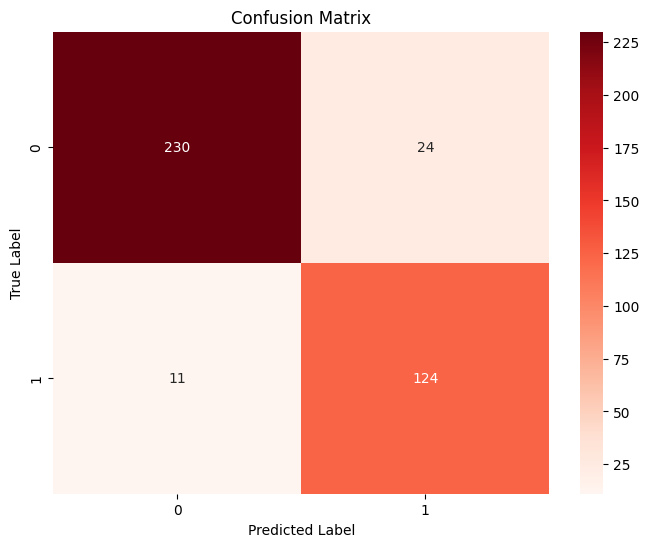

Accuracy: 0.910025706940874
F1 Score (Class 1): 0.8763250883392226
Recall (Macro): 0.9120151647710703
Precision (Macro): 0.8960973421554335


In [10]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-370')
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_1 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])
df_merged_1 = pd.concat([df_dev, df_predictions_1], axis=1)
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_1['label']
predicted_labels = df_merged_1['predicted_label']
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_1.to_csv('debertav3L_task5_predictions_001_epoch_1.csv', index=False)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

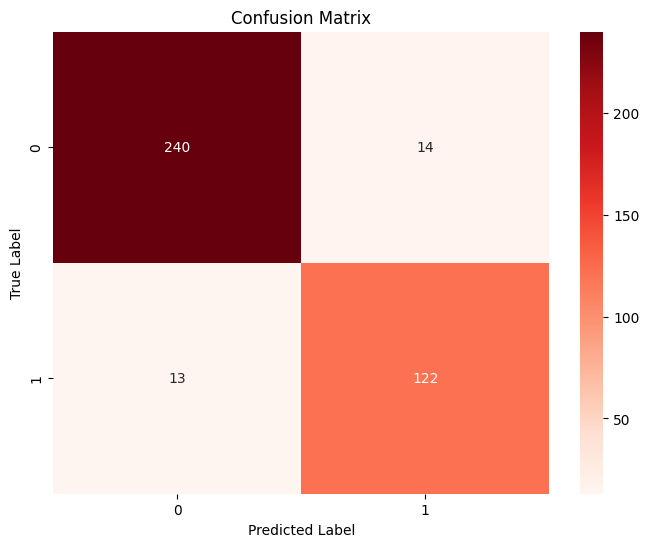

Accuracy: 0.9305912596401028
F1 Score (Class 1): 0.9003690036900369
Recall (Macro): 0.9242927967337415
Precision (Macro): 0.9228377121599628


In [11]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-740')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_2 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_2 = pd.concat([df_dev, df_predictions_2], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_2['label']                                                                                               # HERE
predicted_labels = df_merged_2['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_2.to_csv('debertav3L_task5_predictions_001_epoch_2.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

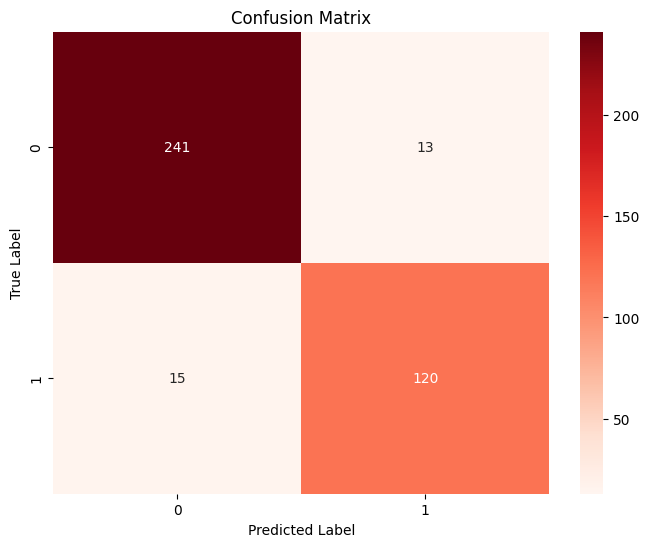

Accuracy: 0.9280205655526992
F1 Score (Class 1): 0.8955223880597015
Recall (Macro): 0.9188538932633421
Precision (Macro): 0.9218309445488722


In [12]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-1110')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_3 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_3 = pd.concat([df_dev, df_predictions_3], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_3['label']                                                                                               # HERE
predicted_labels = df_merged_3['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_3.to_csv('debertav3L_task5_predictions_001_epoch_3.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

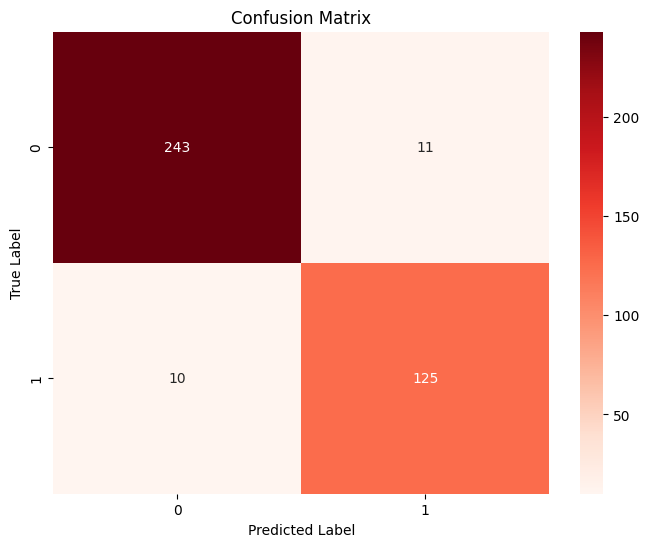

Accuracy: 0.9460154241645244
F1 Score (Class 1): 0.922509225092251
Recall (Macro): 0.9413094196558763
Precision (Macro): 0.9397959776796094


In [13]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-1480')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_4 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_4 = pd.concat([df_dev, df_predictions_4], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_4['label']                                                                                               # HERE
predicted_labels = df_merged_4['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_4.to_csv('debertav3L_task5_predictions_001_epoch_4.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

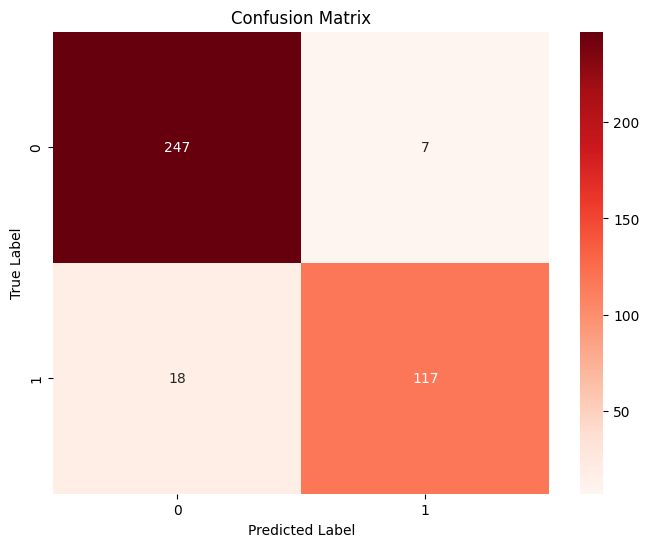

Accuracy: 0.9357326478149101
F1 Score (Class 1): 0.9034749034749036
Recall (Macro): 0.9195538057742783
Precision (Macro): 0.9378119293974437


In [14]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-1850')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_5 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_5 = pd.concat([df_dev, df_predictions_5], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_5['label']                                                                                               # HERE
predicted_labels = df_merged_5['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_5.to_csv('debertav3L_task5_predictions_001_epoch_5.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

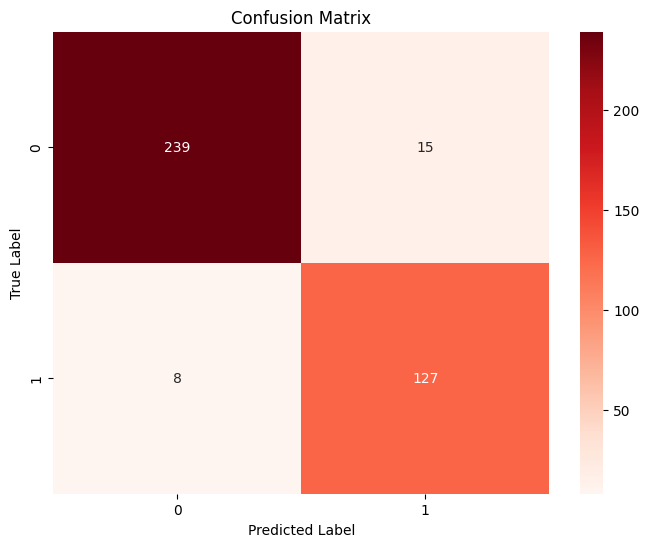

Accuracy: 0.9408740359897172
F1 Score (Class 1): 0.9169675090252708
Recall (Macro): 0.9408428113152523
Precision (Macro): 0.9309887666077437


In [15]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-2220')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_6 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_6 = pd.concat([df_dev, df_predictions_6], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_6['label']                                                                                               # HERE
predicted_labels = df_merged_6['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_6.to_csv('debertav3L_task5_predictions_001_epoch_6.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

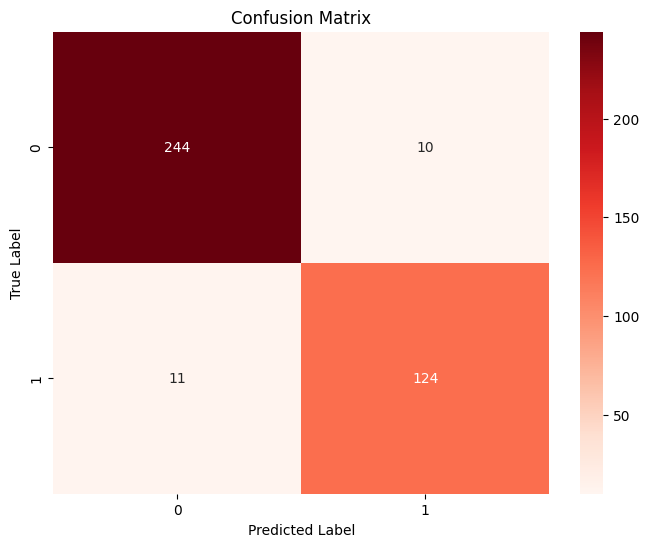

Accuracy: 0.9460154241645244
F1 Score (Class 1): 0.9219330855018587
Recall (Macro): 0.9395742198891806
Precision (Macro): 0.9411179397131988


In [16]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-2590')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_7 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_7 = pd.concat([df_dev, df_predictions_7], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_7['label']                                                                                               # HERE
predicted_labels = df_merged_7['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_7.to_csv('debertav3L_task5_predictions_001_epoch_7.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

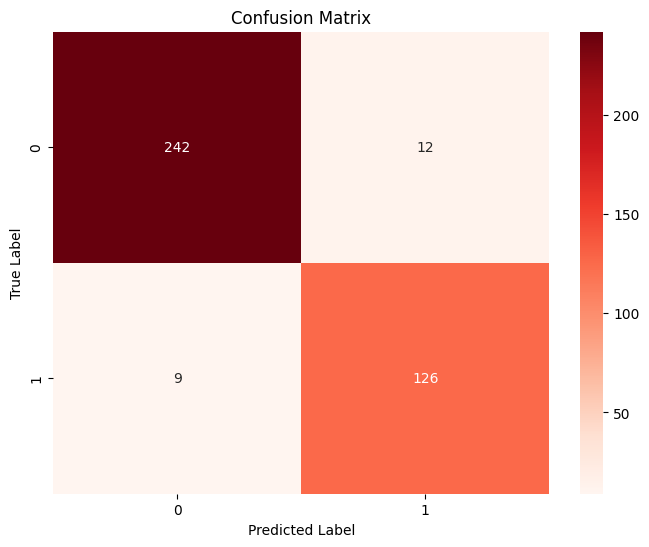

Accuracy: 0.9460154241645244
F1 Score (Class 1): 0.9230769230769231
Recall (Macro): 0.9430446194225721
Precision (Macro): 0.9385934522778452


In [17]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-2960')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_8 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_8 = pd.concat([df_dev, df_predictions_8], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_8['label']                                                                                               # HERE
predicted_labels = df_merged_8['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_8.to_csv('debertav3L_task5_predictions_001_epoch_8.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

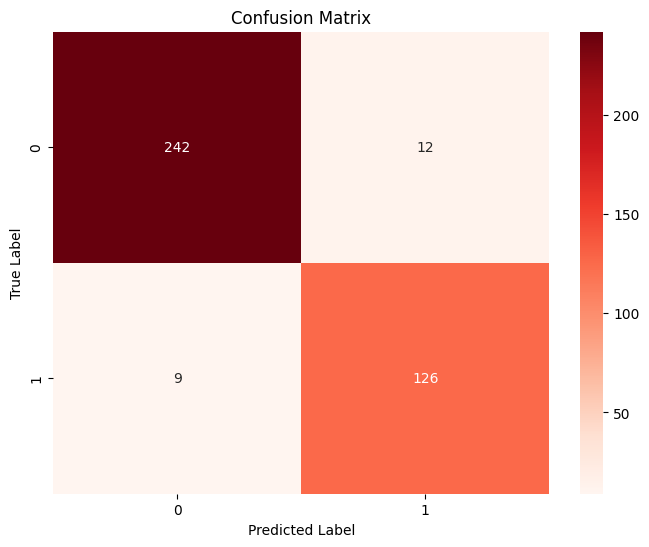

Accuracy: 0.9460154241645244
F1 Score (Class 1): 0.9230769230769231
Recall (Macro): 0.9430446194225721
Precision (Macro): 0.9385934522778452


In [18]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-3330')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_9 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_9 = pd.concat([df_dev, df_predictions_9], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_9['label']                                                                                               # HERE
predicted_labels = df_merged_9['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_9.to_csv('debertav3L_task5_predictions_001_epoch_9.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

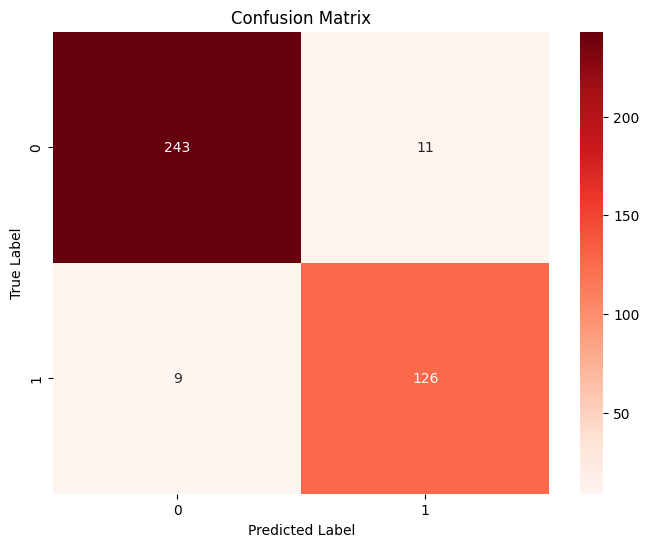

Accuracy: 0.9485861182519281
F1 Score (Class 1): 0.926470588235294
Recall (Macro): 0.94501312335958
Precision (Macro): 0.9419968717413973


In [19]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-3700')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_10 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_10 = pd.concat([df_dev, df_predictions_10], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_10['label']                                                                                               # HERE
predicted_labels = df_merged_10['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_10.to_csv('debertav3L_task5_predictions_001_epoch_10.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

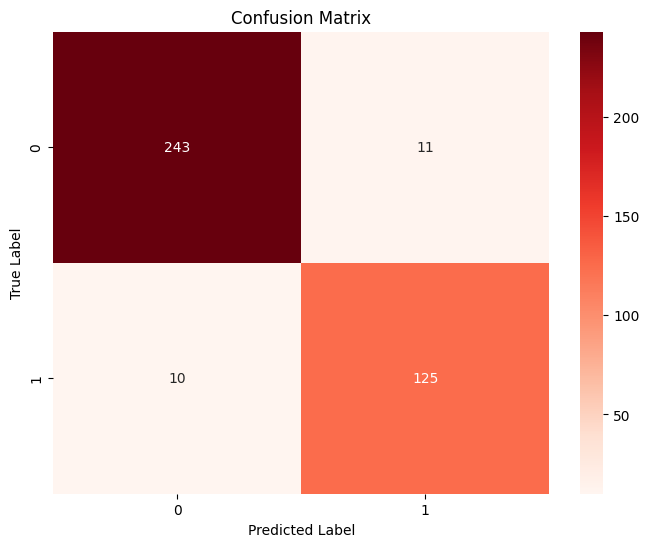

Accuracy: 0.9460154241645244
F1 Score (Class 1): 0.922509225092251
Recall (Macro): 0.9413094196558763
Precision (Macro): 0.9397959776796094


In [20]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-4070')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_11 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_11 = pd.concat([df_dev, df_predictions_11], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_11['label']                                                                                               # HERE
predicted_labels = df_merged_11['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_11.to_csv('debertav3L_task5_predictions_001_epoch_11.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

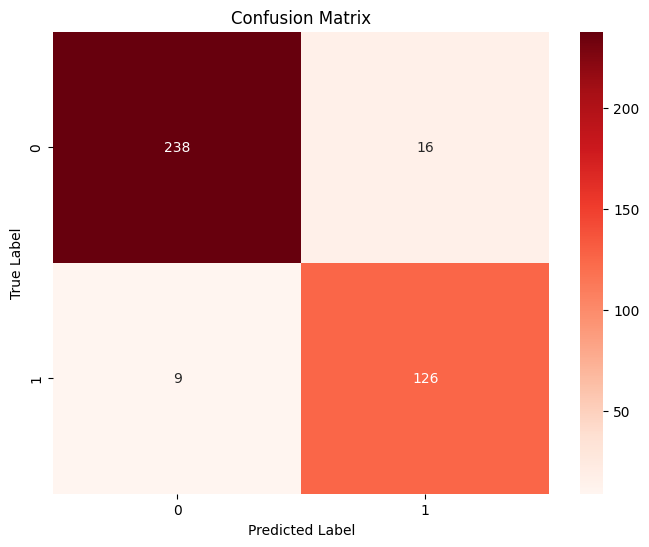

Accuracy: 0.9357326478149101
F1 Score (Class 1): 0.9097472924187726
Recall (Macro): 0.9351706036745406
Precision (Macro): 0.9254433483492046


In [21]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-4440')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_12 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_12 = pd.concat([df_dev, df_predictions_12], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_12['label']                                                                                               # HERE
predicted_labels = df_merged_12['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_12.to_csv('debertav3L_task5_predictions_001_epoch_12.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

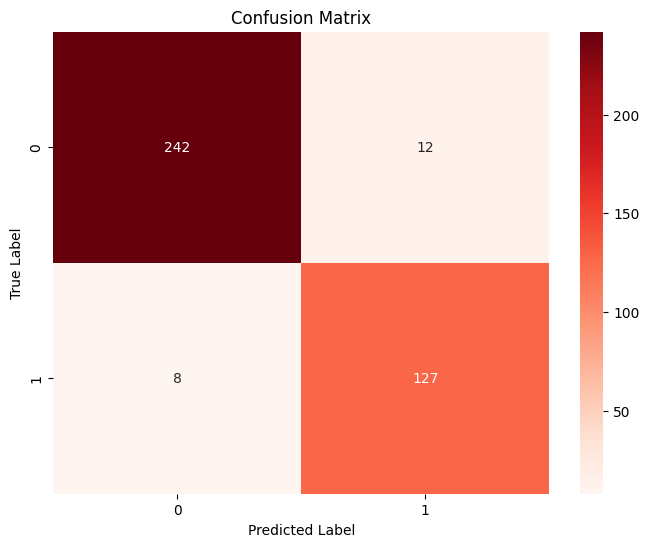

Accuracy: 0.9485861182519281
F1 Score (Class 1): 0.927007299270073
Recall (Macro): 0.9467483231262759
Precision (Macro): 0.9408345323741008


In [22]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-4810')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_13 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_13 = pd.concat([df_dev, df_predictions_13], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_13['label']                                                                                               # HERE
predicted_labels = df_merged_13['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_13.to_csv('debertav3L_task5_predictions_001_epoch_13.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

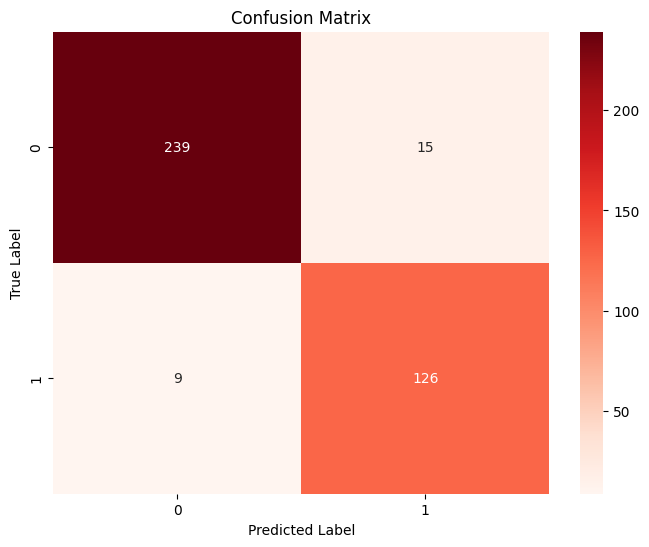

Accuracy: 0.9383033419023136
F1 Score (Class 1): 0.9130434782608695
Recall (Macro): 0.9371391076115485
Precision (Macro): 0.9286633493479752


In [23]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-5180')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_14 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_14 = pd.concat([df_dev, df_predictions_14], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_14['label']                                                                                               # HERE
predicted_labels = df_merged_14['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_14.to_csv('debertav3L_task5_predictions_001_epoch_14.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

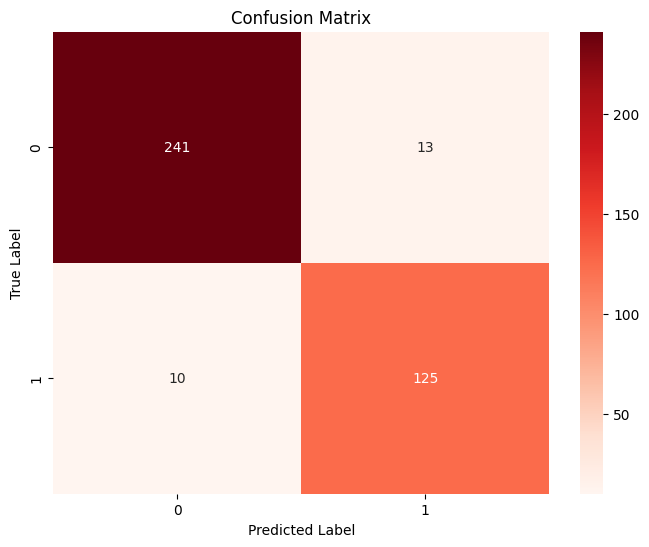

Accuracy: 0.9408740359897172
F1 Score (Class 1): 0.9157509157509157
Recall (Macro): 0.9373724117818606
Precision (Macro): 0.9329782319995381


In [24]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-5550')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_15 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_15 = pd.concat([df_dev, df_predictions_15], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_15['label']                                                                                               # HERE
predicted_labels = df_merged_15['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_15.to_csv('debertav3L_task5_predictions_001_epoch_15.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

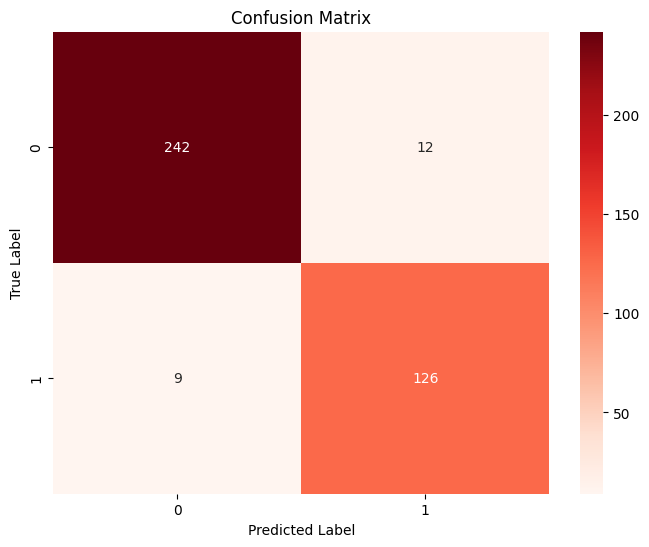

Accuracy: 0.9460154241645244
F1 Score (Class 1): 0.9230769230769231
Recall (Macro): 0.9430446194225721
Precision (Macro): 0.9385934522778452


In [25]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-5920')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_16 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_16 = pd.concat([df_dev, df_predictions_16], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_16['label']                                                                                               # HERE
predicted_labels = df_merged_16['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_16.to_csv('debertav3L_task5_predictions_001_epoch_16.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

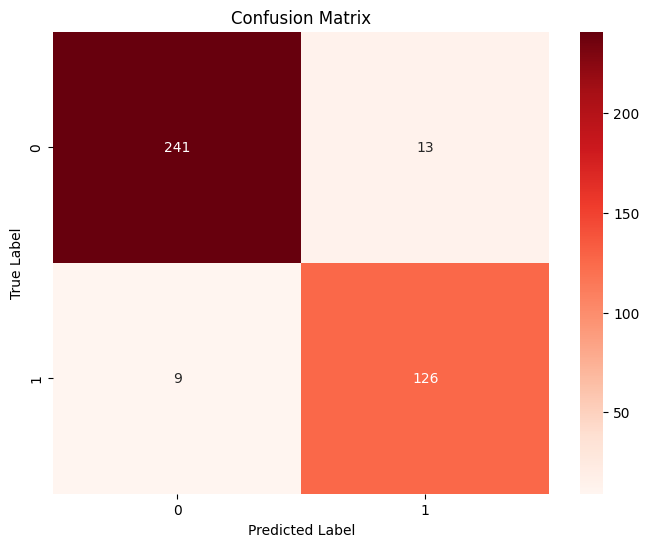

Accuracy: 0.9434447300771208
F1 Score (Class 1): 0.9197080291970804
Recall (Macro): 0.9410761154855642
Precision (Macro): 0.9352374100719425


In [26]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-6290')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_17 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_17 = pd.concat([df_dev, df_predictions_17], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_17['label']                                                                                               # HERE
predicted_labels = df_merged_17['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_17.to_csv('debertav3L_task5_predictions_001_epoch_17.csv', index=False)                                                          # HERE  # HERE

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

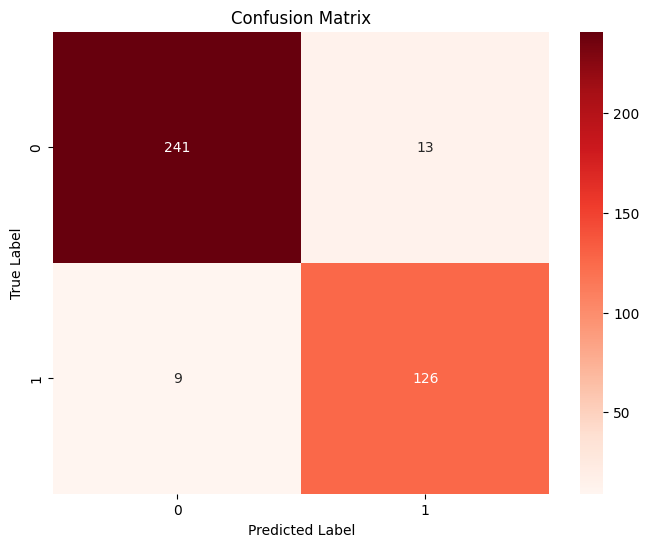

Accuracy: 0.9434447300771208
F1 Score (Class 1): 0.9197080291970804
Recall (Macro): 0.9410761154855642
Precision (Macro): 0.9352374100719425


In [28]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-6660')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_18 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_18 = pd.concat([df_dev, df_predictions_18], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_18['label']                                                                                               # HERE
predicted_labels = df_merged_18['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_18.to_csv('debertav3L_task5_predictions_001_epoch_18.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

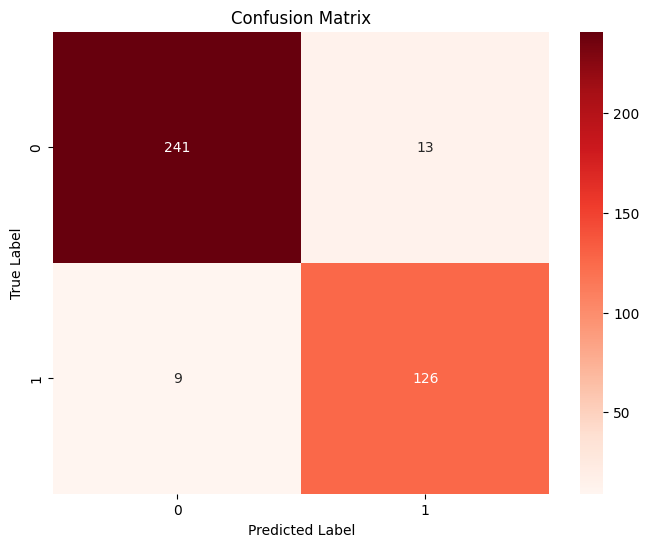

Accuracy: 0.9434447300771208
F1 Score (Class 1): 0.9197080291970804
Recall (Macro): 0.9410761154855642
Precision (Macro): 0.9352374100719425


In [29]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-7030')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_19 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_19 = pd.concat([df_dev, df_predictions_19], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_19['label']                                                                                               # HERE
predicted_labels = df_merged_19['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_19.to_csv('debertav3L_task5_predictions_001_epoch_19.csv', index=False)                                                          # HERE  # HERE

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

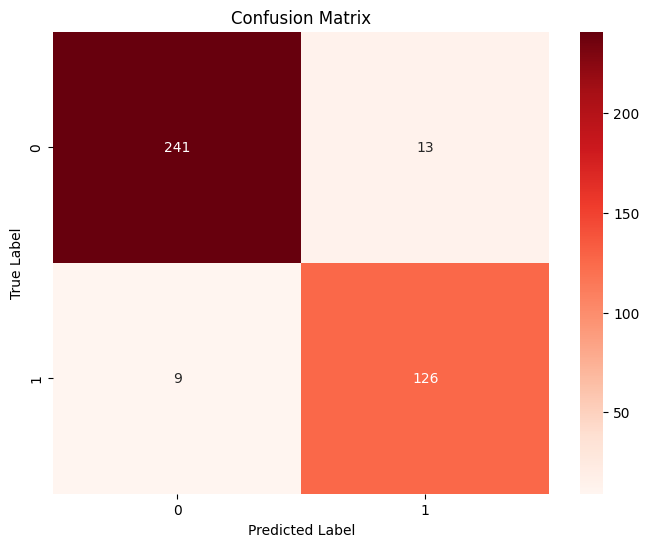

Accuracy: 0.9434447300771208
F1 Score (Class 1): 0.9197080291970804
Recall (Macro): 0.9410761154855642
Precision (Macro): 0.9352374100719425


In [30]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/results_temp/checkpoint-7400')                              # HERE
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=36, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_20 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])          # HERE
df_merged_20 = pd.concat([df_dev, df_predictions_20], axis=1)                                                                      # HERE  # HERE
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
true_labels = df_merged_20['label']                                                                                               # HERE
predicted_labels = df_merged_20['predicted_label']                                                                                # HERE
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_20.to_csv('debertav3L_task5_predictions_001_epoch_20.csv', index=False)                                                          # HERE  # HERE

In [31]:
df_gpt = pd.read_csv('/content/GPT4_Task5_001_Dev_preds.csv')
df_gpt

,tweet_id,text,label,pred
0,1265323726570225669,Mom Finds Secret to Homeschooling her Autistic...,0,0
1,1254180961622900738,I hope our child has my calmness and NOT Andre...,0,1
2,800336385399885824,Blind Girl With Autism Mimics Whitney Houston ...,0,0
3,1107948318150152192,"@amyschumer watching #growing, my 2yo son has ...",1,1
4,1438320313511473154,@robbystarbuck @AmericanAir would rather a mot...,0,0
...,...,...,...,...
384,1479160193808273413,my 7yo is being tested for adhd and struggles ...,0,1
385,1084086161667252225,@attachedmrsL the first reply on the tweet tho...,0,0
386,1404612356819374080,There's a mom who recorded her autistic son &a...,0,0
387,1458807608052174856,@itsadollthxng Lmfao girl !!! I’m upset fr cau...,1,1


In [32]:
df_merged_20

,tweet_id,text,label,predicted_label,prediction_0_weight,prediction_1_weight
0,1265323726570225669,Mom Finds Secret to Homeschooling her Autistic...,0,0,0.999993,0.000007
1,1254180961622900738,I hope our child has my calmness and NOT Andre...,0,0,0.999993,0.000007
2,800336385399885824,Blind Girl With Autism Mimics Whitney Houston ...,0,0,0.999993,0.000007
3,1107948318150152192,"watching my 2yo son has ASD, you just made me...",1,1,0.000004,0.999996
4,1438320313511473154,would rather a mother suffocate an asthmatic ...,0,0,0.999993,0.000007
...,...,...,...,...,...,...
384,1479160193808273413,my 7yo is being tested for adhd and struggles ...,0,0,0.999993,0.000007
385,1084086161667252225,"the first reply on the tweet though 🤣 yes, I ...",0,0,0.999993,0.000007
386,1404612356819374080,There's a mom who recorded her autistic son &a...,0,0,0.999993,0.000007
387,1458807608052174856,Lmfao girl !!! I’m upset fr cause jacelyn has...,1,1,0.000003,0.999997


In [33]:
df_gpt4_20 = df_merged_20.join(df_gpt.iloc[:, -1].rename('pred_gpt4'))
df_gpt4_20

,tweet_id,text,label,predicted_label,prediction_0_weight,prediction_1_weight,pred_gpt4
0,1265323726570225669,Mom Finds Secret to Homeschooling her Autistic...,0,0,0.999993,0.000007,0
1,1254180961622900738,I hope our child has my calmness and NOT Andre...,0,0,0.999993,0.000007,1
2,800336385399885824,Blind Girl With Autism Mimics Whitney Houston ...,0,0,0.999993,0.000007,0
3,1107948318150152192,"watching my 2yo son has ASD, you just made me...",1,1,0.000004,0.999996,1
4,1438320313511473154,would rather a mother suffocate an asthmatic ...,0,0,0.999993,0.000007,0
...,...,...,...,...,...,...,...
384,1479160193808273413,my 7yo is being tested for adhd and struggles ...,0,0,0.999993,0.000007,1
385,1084086161667252225,"the first reply on the tweet though 🤣 yes, I ...",0,0,0.999993,0.000007,0
386,1404612356819374080,There's a mom who recorded her autistic son &a...,0,0,0.999993,0.000007,0
387,1458807608052174856,Lmfao girl !!! I’m upset fr cause jacelyn has...,1,1,0.000003,0.999997,1


In [34]:
df_view = df_gpt4_20[['tweet_id', 'label', 'predicted_label', 'pred_gpt4']]
df_view

,tweet_id,label,predicted_label,pred_gpt4
0,1265323726570225669,0,0,0
1,1254180961622900738,0,0,1
2,800336385399885824,0,0,0
3,1107948318150152192,1,1,1
4,1438320313511473154,0,0,0
...,...,...,...,...
384,1479160193808273413,0,0,1
385,1084086161667252225,0,0,0
386,1404612356819374080,0,0,0
387,1458807608052174856,1,1,1


In [35]:
df_view_0 = df_view[df_view['pred_gpt4'] == 0]
df_view_1 = df_view[df_view['pred_gpt4'] == 1]

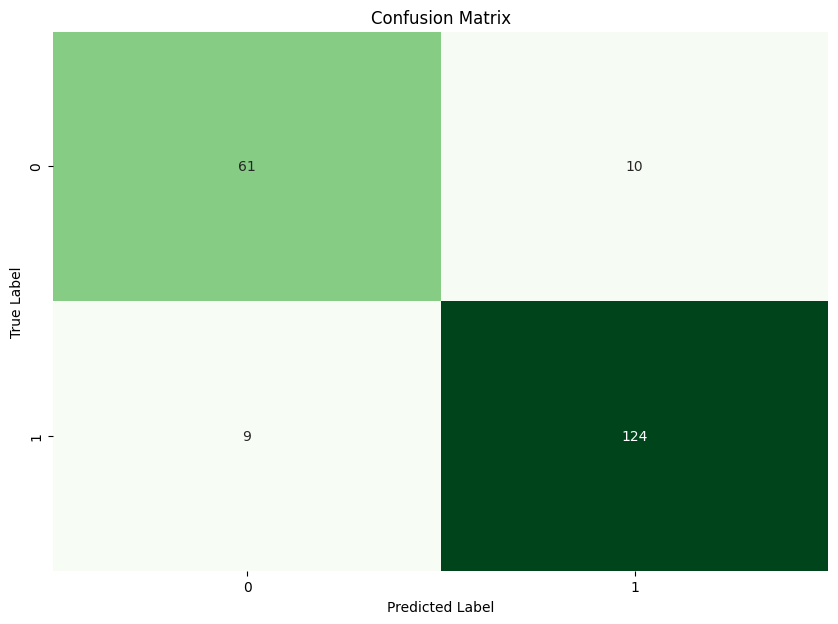

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(df_view_1['label'], df_view_1['predicted_label'])
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

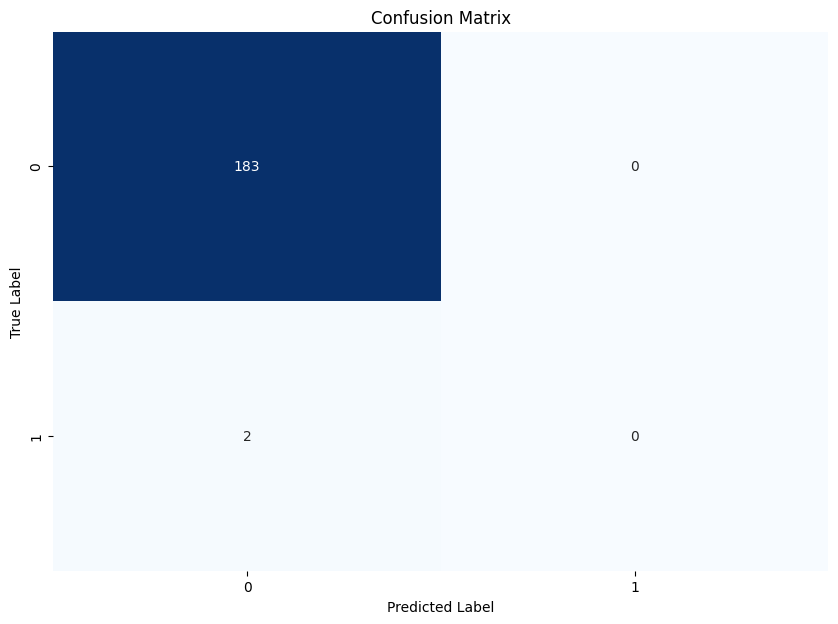

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(df_view_0['label'], df_view_0['pred_gpt4'])
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [38]:
import numpy as np
df_view['final_pred'] = np.where(df_view['pred_gpt4'] == 0, 0, df_view['predicted_label'])
df_view

<ipython-input-38-89ff39692ef4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_view['final_pred'] = np.where(df_view['pred_gpt4'] == 0, 0, df_view['predicted_label'])


,tweet_id,label,predicted_label,pred_gpt4,final_pred
0,1265323726570225669,0,0,0,0
1,1254180961622900738,0,0,1,0
2,800336385399885824,0,0,0,0
3,1107948318150152192,1,1,1,1
4,1438320313511473154,0,0,0,0
...,...,...,...,...,...
384,1479160193808273413,0,0,1,0
385,1084086161667252225,0,0,0,0
386,1404612356819374080,0,0,0,0
387,1458807608052174856,1,1,1,1


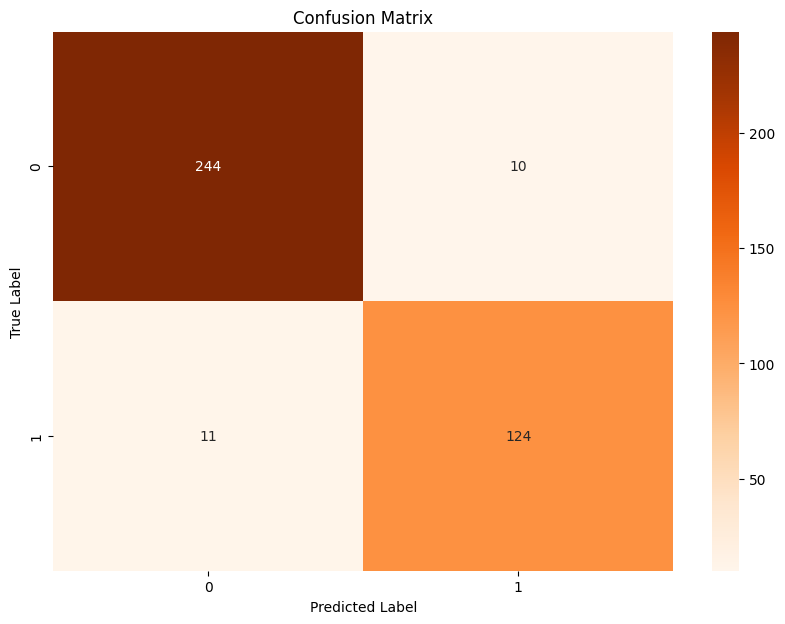

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(df_view['label'], df_view['final_pred'])
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [40]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
y_true = df_view['label']
y_pred = df_view['final_pred']
accuracy = accuracy_score(y_true, y_pred)
f1_class_1 = f1_score(y_true, y_pred, pos_label=1)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")

Accuracy: 0.9460154241645244
F1 Score (Class 1): 0.9219330855018587
Recall (Macro): 0.9395742198891806
Precision (Macro): 0.9411179397131988


In [41]:
df_view

,tweet_id,label,predicted_label,pred_gpt4,final_pred
0,1265323726570225669,0,0,0,0
1,1254180961622900738,0,0,1,0
2,800336385399885824,0,0,0,0
3,1107948318150152192,1,1,1,1
4,1438320313511473154,0,0,0,0
...,...,...,...,...,...
384,1479160193808273413,0,0,1,0
385,1084086161667252225,0,0,0,0
386,1404612356819374080,0,0,0,0
387,1458807608052174856,1,1,1,1


In [42]:
# prompt: Using dataframe df_view: df_view_2 = df_view [ label != predicted_label ]]
df_view_2 = df_view[df_view['label'] != df_view['predicted_label']]
df_view_2

,tweet_id,label,predicted_label,pred_gpt4,final_pred
47,1306936371379142656,0,1,1,1
49,1167618379064233985,0,1,1,1
54,1420240266863075328,0,1,1,1
72,930101586386448385,1,0,1,0
76,992552152106127360,1,0,1,0
90,1487583290781491200,0,1,0,0
126,1385224892946255872,0,1,0,0
131,1210298245517389824,0,1,1,1
212,946571570868379648,0,1,1,1
213,1404021947109941254,1,0,1,0


In [43]:
df_gpt4_20_n = df_gpt4_20[df_gpt4_20['label'] != df_gpt4_20['predicted_label']]
df_gpt4_20_n

,tweet_id,text,label,predicted_label,prediction_0_weight,prediction_1_weight,pred_gpt4
47,1306936371379142656,I'm black with an autistic son....Nah I'm good...,0,1,0.000004,0.999996,1
49,1167618379064233985,Girl same! I’ve been on vacation all week cau...,0,1,0.000010,0.999990,1
54,1420240266863075328,Watching the assembly meeting and taking the n...,0,1,0.000004,0.999996,1
72,930101586386448385,Very similar to the (Specific Carbohydrate Di...,1,0,0.998036,0.001964,1
76,992552152106127360,thinking about my sweet boy as I was accepted ...,1,0,0.999993,0.000007,1
90,1487583290781491200,The farm that I take Joshua to collects the en...,0,1,0.002326,0.997674,0
126,1385224892946255872,AOS or OAS? I get OAS. Just keep an eye on it...,0,1,0.000306,0.999694,0
131,1210298245517389824,Define “something cool.” Does being a working...,0,1,0.000044,0.999956,1
212,946571570868379648,I did shortly after my daughter's 2nd birthda...,0,1,0.000005,0.999995,1
213,1404021947109941254,I knew ONE of my kids would get asthma ... It ...,1,0,0.999670,0.000330,1
